In [1]:
#Vectorisation TF-IDF pour l'Analyse de Sentiment

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer  # Note: on importe depuis 'sklearn' mais le package s'appelle 'scikit-learn'
from scipy.sparse import save_npz, load_npz
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [3]:
#graphical config
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [4]:
df = pd.read_csv("data_cleaned.csv")
print("Aperçu du dataset:")
print(f"Nombre de tweets: {len(df)}")
print(f"Colonnes disponibles: {df.columns.tolist()}\n")

Aperçu du dataset:
Nombre de tweets: 900
Colonnes disponibles: ['Author', 'Tweet', 'Date', 'Link', 'Images', 'Retweets', 'Replies', 'Likes', 'Unnamed: 3', 'Unnamed: 4', 'langue', 'tweet_cleaned', 'tokens', 'text_final']



In [5]:
#TF-IDF

In [6]:
# Paramètres du vectoriseur
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,          # Limiter aux 5000 mots les plus importants
    min_df=3,                   # Ignorer les mots apparaissant dans moins de 3 documents
    max_df=0.8,                 # Ignorer les mots trop fréquents (> 80% des docs)
    ngram_range=(1, 2),         # Unigrammes et bigrammes
    sublinear_tf=True,          # Scaling logarithmique sur tf
    strip_accents='unicode',    # Normaliser les accents
    lowercase=True,             # Tout en minuscules
    analyzer='word'             # Analyse par mots
)

In [7]:
print(f"  - Max features: {tfidf_vectorizer.max_features}")
print(f"  - Min document frequency: {tfidf_vectorizer.min_df}")
print(f"  - Max document frequency: {tfidf_vectorizer.max_df}")
print(f"  - N-gram range: {tfidf_vectorizer.ngram_range}")


  - Max features: 5000
  - Min document frequency: 3
  - Max document frequency: 0.8
  - N-gram range: (1, 2)


In [8]:
## 4. Transformation en matrice TF-IDF

In [9]:
X_tfidf = tfidf_vectorizer.fit_transform(df['Tweet'])

print(f" Forme de la matrice: {X_tfidf.shape}")
print(f"  - Nombre de documents: {X_tfidf.shape[0]}")
print(f"  - Nombre de features: {X_tfidf.shape[1]}")
print(f"  - Éléments non-zéro: {X_tfidf.nnz:,}")
print(f"  - Sparsité: {(1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])) * 100:.2f}%")
print(f"  - Score min: {X_tfidf.data.min():.4f}")
print(f"  - Score max: {X_tfidf.data.max():.4f}")
print(f"  - Score moyen: {X_tfidf.data.mean():.4f}")


 Forme de la matrice: (900, 5000)
  - Nombre de documents: 900
  - Nombre de features: 5000
  - Éléments non-zéro: 55,870
  - Sparsité: 98.76%
  - Score min: 0.0181
  - Score max: 1.0000
  - Score moyen: 0.1117


In [ ]:
#saving  matrix 

In [12]:
save_npz('tfidf_matrix.npz', X_tfidf)
print("Matrice sauvegardée: tfidf_matrix.npz")

Matrice sauvegardée: tfidf_matrix.npz


In [ ]:
#saving vectorizer

In [13]:
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print("Vectoriseur sauvegardé: tfidf_vectorizer.pkl")


Vectoriseur sauvegardé: tfidf_vectorizer.pkl


In [ ]:
#save vocabulary

In [14]:
feature_names = tfidf_vectorizer.get_feature_names_out()
vocab_df = pd.DataFrame({
    'feature': feature_names,
    'index': range(len(feature_names))
})
vocab_df.to_csv('tfidf_vocabulary.csv', index=False)
print("✓ Vocabulaire sauvegardé: tfidf_vocabulary.csv")


✓ Vocabulaire sauvegardé: tfidf_vocabulary.csv


In [15]:
# Calculer l'importance moyenne de chaque feature
feature_importance = np.asarray(X_tfidf.mean(axis=0)).flatten()
feature_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 30 des features les plus importantes:\n")
display(feature_df.head(30))

Top 30 des features les plus importantes:



,feature,importance
1136,de,0.049143
2650,la,0.039351
2811,les,0.037347
1410,des,0.034858
1694,du,0.031748
1830,en,0.030150
2739,le,0.029875
2031,et,0.029758
4796,universite,0.027759
3814,pour,0.027593


In [17]:
# Sauvegarder
feature_df.to_csv('tfidf_feature_importance.csv', index=False)
print("\n Importance des features sauvegardée")


 Importance des features sauvegardée


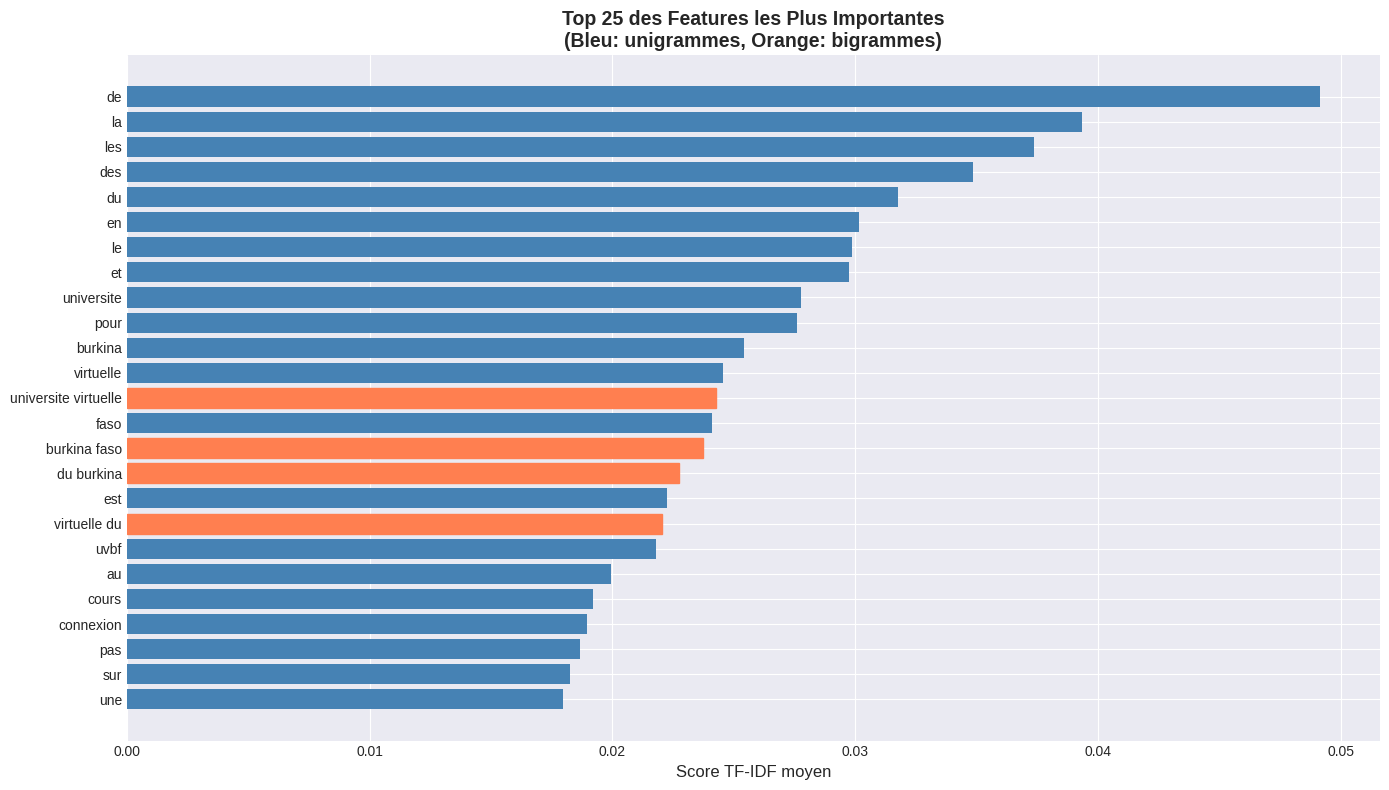

Graphique sauvegardé: top_features_tfidf.png


In [21]:
## 7. Visualisation: Top Features

plt.figure(figsize=(14, 8))

top_features = feature_df.head(25)
bars = plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')

# Colorer différemment les bigrammes
for i, (idx, row) in enumerate(top_features.iterrows()):
    if ' ' in row['feature']:
        bars[i].set_color('coral')

plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
plt.xlabel('Score TF-IDF moyen', fontsize=12)
plt.title('Top 25 des Features les Plus Importantes\n(Bleu: unigrammes, Orange: bigrammes)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top_features_tfidf.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé: top_features_tfidf.png")


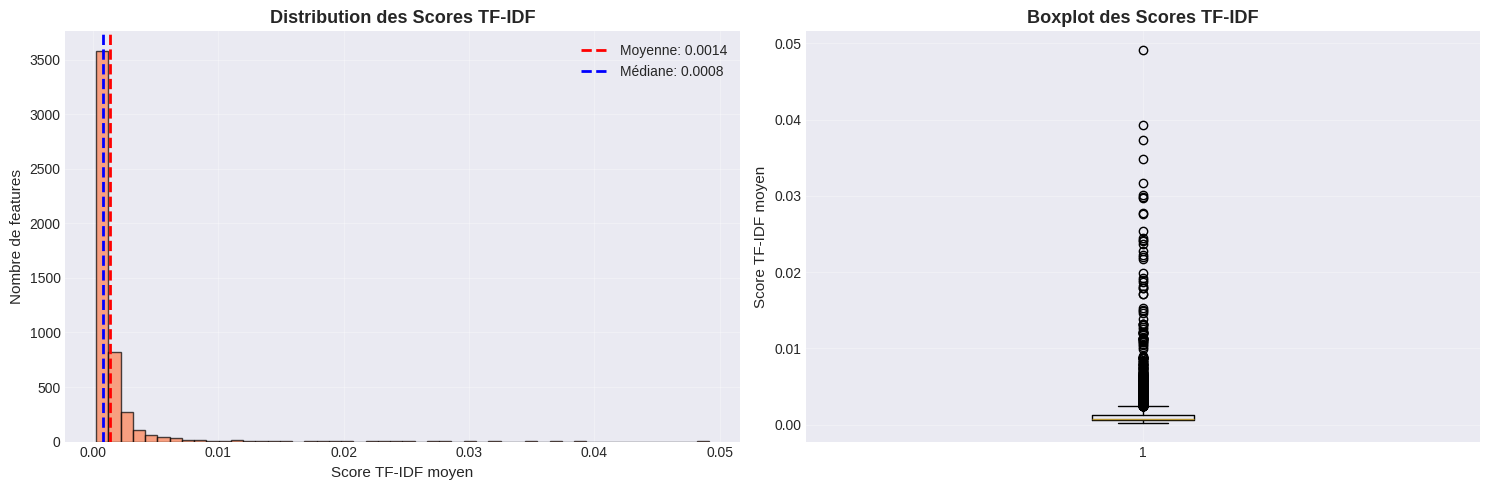

✓ Graphique sauvegardé: tfidf_distribution.png


In [19]:
## 8. Distribution des scores TF-IDF

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogramme
axes[0].hist(feature_importance, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].axvline(feature_importance.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Moyenne: {feature_importance.mean():.4f}')
axes[0].axvline(np.median(feature_importance), color='blue', linestyle='--', 
                linewidth=2, label=f'Médiane: {np.median(feature_importance):.4f}')
axes[0].set_xlabel('Score TF-IDF moyen', fontsize=11)
axes[0].set_ylabel('Nombre de features', fontsize=11)
axes[0].set_title('Distribution des Scores TF-IDF', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(feature_importance, vert=True)
axes[1].set_ylabel('Score TF-IDF moyen', fontsize=11)
axes[1].set_title('Boxplot des Scores TF-IDF', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tfidf_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé: tfidf_distribution.png")

Statistiques des bigrammes:
  - Nombre total: 3199
  - % du vocabulaire: 64.0%

Top 20 des bigrammes:



,feature,importance
4810,universite virtuelle,0.024259
585,burkina faso,0.023731
1710,du burkina,0.022741
4895,virtuelle du,0.022035
1227,de la,0.017125
4833,uv bf,0.013848
2825,les cours,0.013260
2663,la connexion,0.012106
2248,faso uvbf,0.011862
1865,en ligne,0.011421


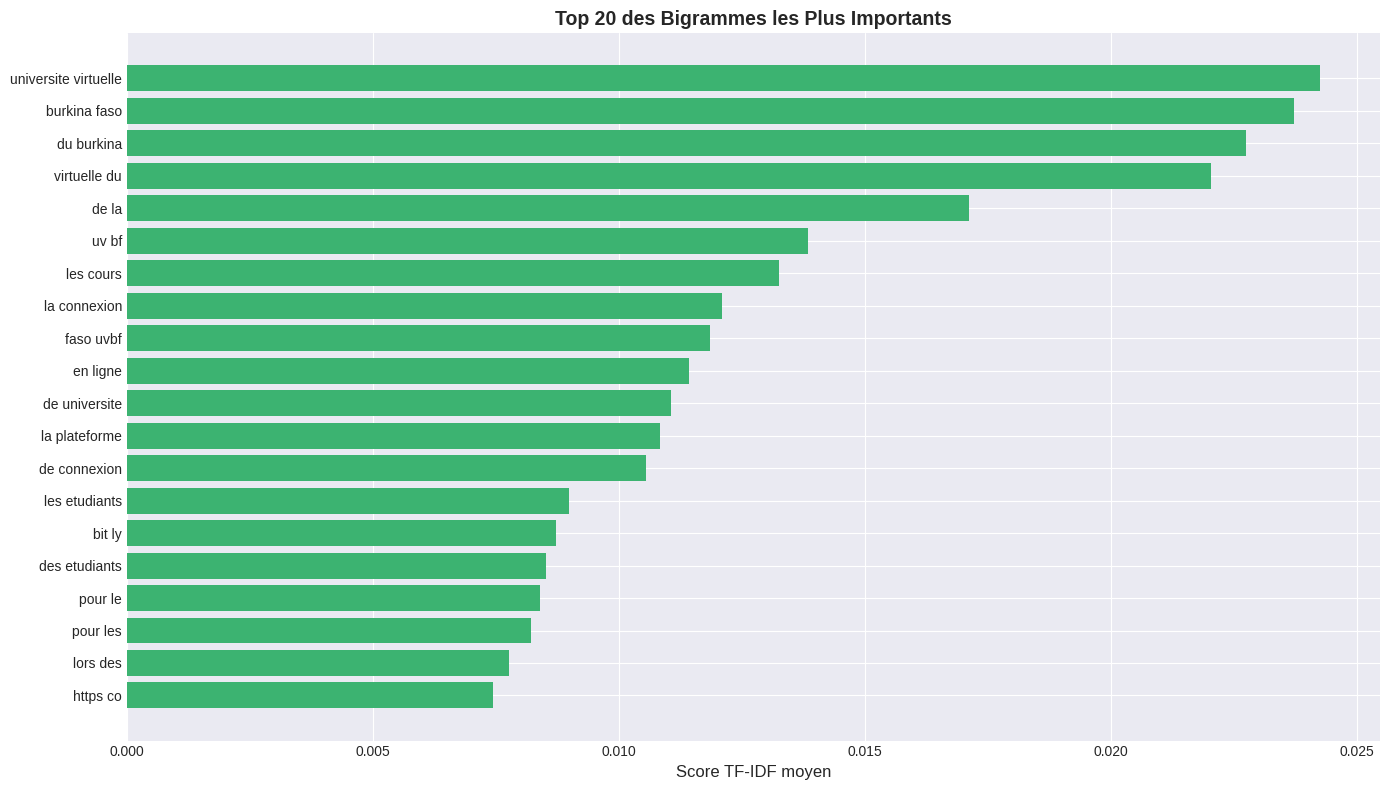


✓ Graphique sauvegardé: top_bigrams_tfidf.png


,Métrique,Valeur
0,Nombre de documents,900.0000
1,Nombre de features,5000.0000
2,Éléments non-zéro,55870.0000
3,Sparsité (%),98.7600
4,Score minimum,0.0181
5,Score maximum,1.0000
6,Score moyen,0.1117
7,Médiane,0.0971
8,Écart-type,0.0603



✓ Statistiques sauvegardées: tfidf_statistics.csv
Test de vectorisation de nouveaux textes:

Texte: 'université virtuelle burkina excellent formation'
  - Forme: (1, 5000)
  - Valeurs non-nulles: 6
  - Top features:
      • excellent: 0.7971
      • formation: 0.3638
      • burkina: 0.2450
      • universite virtuelle: 0.2432
      • virtuelle: 0.2418

Texte: 'connexion internet problème plateforme'
  - Forme: (1, 5000)
  - Valeurs non-nulles: 5
  - Top features:
      • connexion internet: 0.5617
      • internet: 0.4951
      • probleme: 0.4385
      • plateforme: 0.3670
      • connexion: 0.3353

Texte: 'cours intéressant professeur compétent'
  - Forme: (1, 5000)
  - Valeurs non-nulles: 2
  - Top features:
      • professeur: 0.9131
      • cours: 0.4078



In [20]:
## 9. Analyse des bigrammes

# %%
# Extraire les bigrammes
bigrams = [f for f in feature_names if ' ' in f]
bigram_importance = feature_df[feature_df['feature'].isin(bigrams)].head(20)

print(f"Statistiques des bigrammes:")
print(f"  - Nombre total: {len(bigrams)}")
print(f"  - % du vocabulaire: {len(bigrams)/len(feature_names)*100:.1f}%\n")

if len(bigram_importance) > 0:
    print("Top 20 des bigrammes:\n")
    display(bigram_importance)
    
    # Visualisation
    plt.figure(figsize=(14, 8))
    plt.barh(range(len(bigram_importance)), bigram_importance['importance'], 
             color='mediumseagreen')
    plt.yticks(range(len(bigram_importance)), bigram_importance['feature'], fontsize=10)
    plt.xlabel('Score TF-IDF moyen', fontsize=12)
    plt.title('Top 20 des Bigrammes les Plus Importants', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('top_bigrams_tfidf.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Graphique sauvegardé: top_bigrams_tfidf.png")

# %% [markdown]
## 10. Statistiques détaillées

# %%
stats = {
    'Nombre de documents': X_tfidf.shape[0],
    'Nombre de features': X_tfidf.shape[1],
    'Éléments non-zéro': X_tfidf.nnz,
    'Sparsité (%)': round((1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])) * 100, 2),
    'Score minimum': round(X_tfidf.data.min(), 4),
    'Score maximum': round(X_tfidf.data.max(), 4),
    'Score moyen': round(X_tfidf.data.mean(), 4),
    'Médiane': round(np.median(X_tfidf.data), 4),
    'Écart-type': round(X_tfidf.data.std(), 4)
}

stats_df = pd.DataFrame(list(stats.items()), columns=['Métrique', 'Valeur'])
display(stats_df)

# Sauvegarder
stats_df.to_csv('tfidf_statistics.csv', index=False)
print("\n✓ Statistiques sauvegardées: tfidf_statistics.csv")

# %% [markdown]
## 11. Test de réutilisation du modèle

# %%
# Charger le vectoriseur sauvegardé
with open('tfidf_vectorizer.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)

# Tester avec un nouveau texte
textes_test = [
    "université virtuelle burkina excellent formation",
    "connexion internet problème plateforme",
    "cours intéressant professeur compétent"
]

print("Test de vectorisation de nouveaux textes:\n")
for texte in textes_test:
    vecteur = loaded_vectorizer.transform([texte])
    
    print(f"Texte: '{texte}'")
    print(f"  - Forme: {vecteur.shape}")
    print(f"  - Valeurs non-nulles: {vecteur.nnz}")
    
    # Afficher les top features
    if vecteur.nnz > 0:
        indices = vecteur.nonzero()[1]
        scores = vecteur.data
        feature_scores = [(feature_names[idx], score) for idx, score in zip(indices, scores)]
        feature_scores.sort(key=lambda x: x[1], reverse=True)
        print("  - Top features:")
        for feature, score in feature_scores[:5]:
            print(f"      • {feature}: {score:.4f}")
    print()